In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.CNN import CNNActionValue
from src.evaluate import evaluate
import src.DQN as DQN
from src.Preprocess import preprocess, ImageEnv

In [2]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


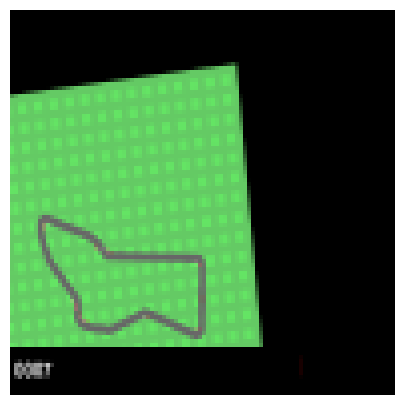

In [3]:
s, info = env.reset()
print(s.shape)

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

The shape of an observation:  (4, 84, 84)


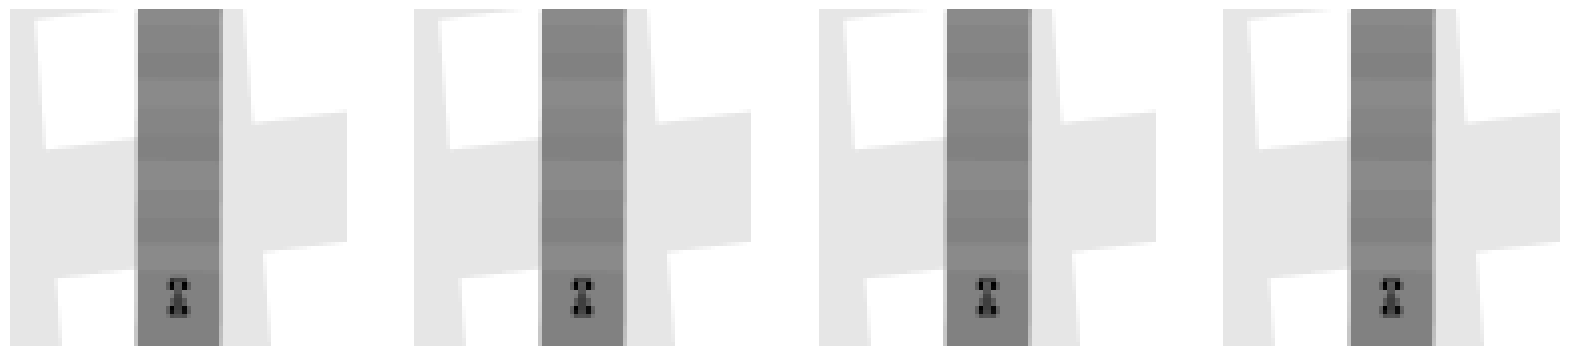

In [4]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [5]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(1e5)
eval_interval = 1000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQN.DQN(state_dim, action_dim)

cuda


In [6]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

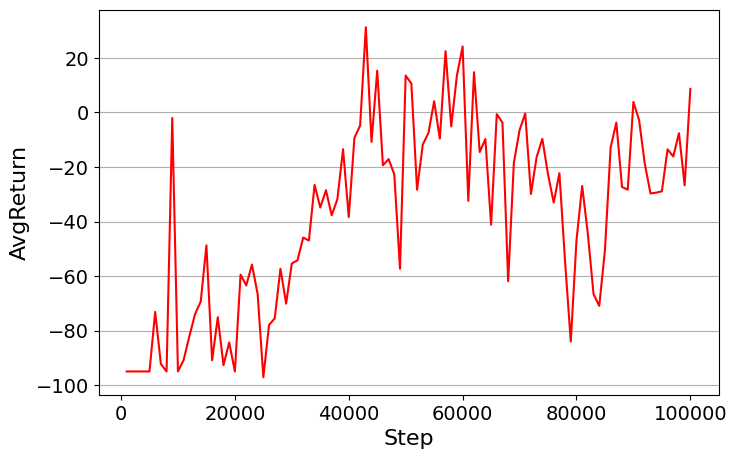

In [7]:
from IPython.display import clear_output

history = {'Step': [], 'AvgReturn': []}
loss_history = {'total_steps': [], 'value_loss': []}

(s, _) = env.reset()
while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.
    
    if result: #warm up 단계일 경우 x 
        loss_history['total_steps'].append(result['total_steps'])
        loss_history['value_loss'].append(result['value_loss'])
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        #torch.save(agent.network.state_dict(), 'dqn.pt')
    
    if agent.total_steps > max_steps:
        break

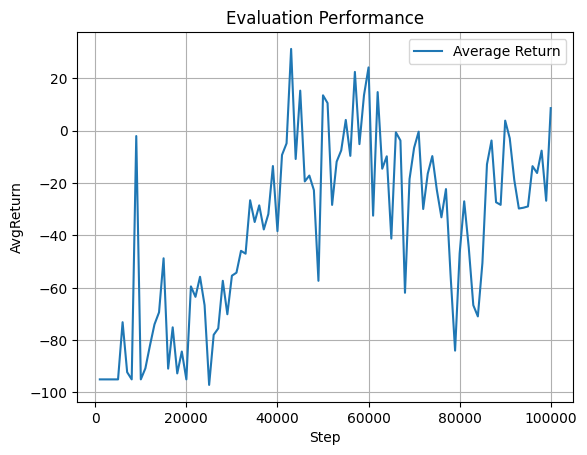

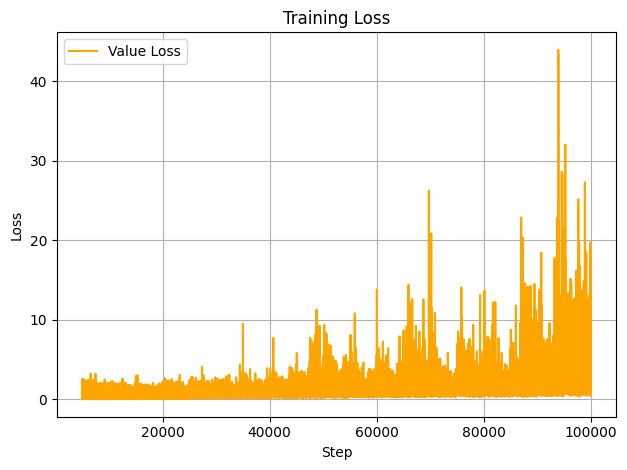

In [13]:
# 평균 리턴 그래프
plt.plot(history['Step'], history['AvgReturn'], label='Average Return')
plt.xlabel('Step')
plt.ylabel('AvgReturn')
plt.title('Evaluation Performance')
plt.grid(True)
plt.legend()
plt.show()
# Loss 그래프
plt.plot(loss_history['total_steps'], loss_history['value_loss'], label='Value Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()

# 화면에 표시
plt.show()

In [14]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret


print(scores)

-9.285714285714828


In [ ]:
import pickle

# 저장
with open("data/normal_history.pkl", "wb") as f:
    pickle.dump(history, f)

with open("data/normal_loss_history.pkl", "wb") as f:
    pickle.dump(loss_history, f)

torch.save(agent.network.state_dict(), 'data/nomal_dqn.pt')


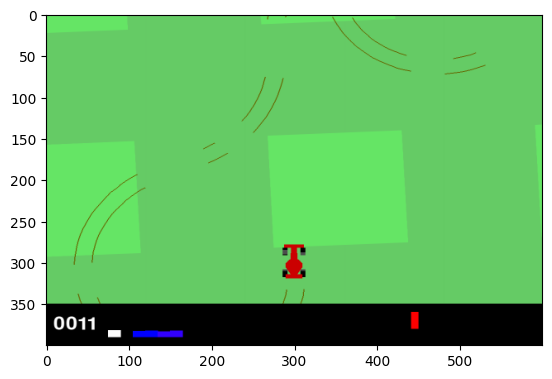

In [9]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

# 애니메이션을 저장
ani.save('nomal_car_racing_result.gif', writer='pillow')

plt.show()

In [6]:
agent.network.load_state_dict(torch.load('data/nomal_dqn.pt'))
agent.target_network.load_state_dict(agent.network.state_dict())



env = gym.make('CarRacing-v2',continuous=False, render_mode="human")
env = ImageEnv(env)

s, _ = env.reset()

done = False
while not done:
    a = agent.act(s, training=False)
    s, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated


C:\Users\eunli\AppData\Local\Temp\ipykernel_3164\2059456194.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.network.load_state_dict(torch.load('data/nomal_dqn.pt')

In [7]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os

# 저장할 폴더 생성
os.makedirs("videos", exist_ok=True)

# 환경 생성 (render_mode = "rgb_array" 로 설정해야 영상 저장 가능)
env = gym.make("CarRacing-v2", render_mode="rgb_array")

# 영상 저장 래퍼 적용
env = RecordVideo(env, video_folder="videos", episode_trigger=lambda episode_id: True)

# 에피소드 시작
s, _ = env.reset()
done = False

while not done:
    # 행동 선택 (여기선 랜덤으로 예시)
    a = env.action_space.sample()  # 학습된 agent.act로 교체 가능
    s, r, terminated, truncated, info = env.step(a)

    done = terminated or truncated

env.close()

print("영상 저장 완료: videos 폴더 확인")


c:\Users\eunli\anaconda3\envs\rl38\lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at c:\강화학습모델\DQN-CarRacing\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\강화학습모델\DQN-CarRacing\videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\강화학습모델\DQN-CarRacing\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\강화학습모델\DQN-CarRacing\videos\rl-video-episode-0.mp4
영상 저장 완료: videos 폴더 확인
